# Telco Churn Data Analysis Report
## Table of Contents
1. [Objective](#objective)
2. [Data Loading (SQL)](#data-loading)
3. [Data Quality Checks](#data-quality-checks)
4. [Exploratory Data Analysis](#exploratory-data-analysis)
5. [Feature Engineering](#feature-engineering)
6. [Modelling](#modelling)
7. [Evaluation](#evaluation)
8. [Conclusion / Next Steps](#conclusion)

## Objective
- Perform initial data loading onto postgresql server 
- Conduct Exploratory Data analysis to clean churn data and find trends
- Prepare the dataset for ML through cleaning and feature engineering
- Train and evaluate the classification model to predict customer churn

## Data Loading
This section is to detail how the data is loaded as a dataframe from the CSV file downloaded from Kaggle, and then loaded postgreSQL database "telco_customer" using sqlalchemy.

This allows us to:
1. Store data in database
2. Easily query subsets with SQL
3. Keep workflow reproducible


In [30]:
# Load Data from CSV file
import pandas as pd

df = pd.read_csv("../data/raw/telco_customer.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [32]:
# Connect to Database and Insert Data
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

# Force update of environment variables
load_dotenv(override=True)

# connect to database and create table from dataframe
url = os.getenv("DATABASE_URL")
engine = create_engine(url)
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
df.to_sql('telco_customer', con=engine, if_exists='replace', index=False)

# Query the Database to Verify Insertion
query = "SELECT * FROM telco_customer LIMIT 5;"
result = pd.read_sql(query, con=engine)
print(result)

   customerid  gender  seniorcitizen partner dependents  tenure phoneservice  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      multiplelines internetservice onlinesecurity  ... deviceprotection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  techsupport streamingtv streamingmovies        contract pape

## Data Quality Checks
Before cleaning and analysis, we aim to find:
- missing values
- incorrect data types
- duplicates 

In [ ]:
query = "SELECT * FROM telco_customer;"
all_data = pd.read_sql(query, con=engine)
print(all_data.info())
print(all_data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   phoneservice      7043 non-null   object 
 7   multiplelines     7043 non-null   object 
 8   internetservice   7043 non-null   object 
 9   onlinesecurity    7043 non-null   object 
 10  onlinebackup      7043 non-null   object 
 11  deviceprotection  7043 non-null   object 
 12  techsupport       7043 non-null   object 
 13  streamingtv       7043 non-null   object 
 14  streamingmovies   7043 non-null   object 
 15  contract          7043 non-null   object 
 16  paperlessbilling  7043 non-null   object 


In [20]:
query = "SELECT COUNT(*) as total_rows FROM telco_customer;"
total_rows = pd.read_sql(query, con=engine)
total_rows

,total_rows
0,7043


In [ ]:
query = """SELECT churn, COUNT(*) FROM telco_customer GROUP BY churn;"""
churn_counts = pd.read_sql(query, con=engine)
churn_counts

,churn,count
0,No,5174
1,Yes,1869


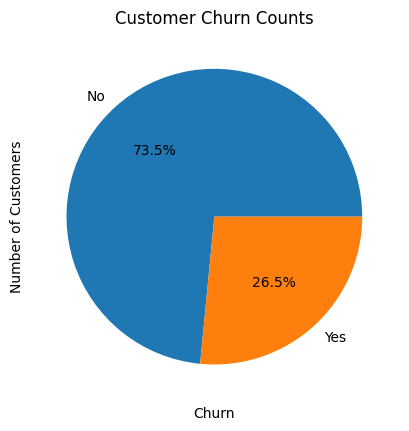

In [38]:
import matplotlib.pyplot as plt

plt.pie(churn_counts['count'], labels=churn_counts['churn'], autopct='%1.1f%%')
plt.title('Customer Churn Counts')  
plt.xlabel('Churn')
plt.ylabel('Number of Customers')
plt.show()

In [ ]:
# Check the data types of each column
query = "SELECT column_name, data_type FROM information_schema.columns WHERE table_name = 'telco_customer';"
data_types = pd.read_sql(query, con=engine)
data_types

,column_name,data_type
0,monthlycharges,double precision
1,seniorcitizen,bigint
2,tenure,bigint
3,dependents,text
4,phoneservice,text
5,multiplelines,text
6,internetservice,text
7,onlinesecurity,text
8,onlinebackup,text
9,deviceprotection,text


We see that totalcharges by inspection should be double precision numbers similar to monthlycharges, but sql has the datatype as text. Hence, we try to fix this by first checking if there are any bad values, and then altering the database type.

In [ ]:
# Analyze the totalcharges column
query = "SELECT totalcharges FROM telco_customer;"
total_charges = pd.read_sql(query, con=engine)
total_charges['totalcharges'] = pd.to_numeric(total_charges['totalcharges'], errors='coerce')

query2 = "SELECT MIN(totalcharges), MAX(totalcharges) FROM telco_customer"
min_max_total_charges = pd.read_sql(query2, con=engine) 
min_max_total_charges




,min,max
0,,999.9


In [72]:
# Alter the totalcharges column to FLOAT type in the database
from sqlalchemy import text
with engine.begin() as conn:
    conn.execute(text("""
        ALTER TABLE telco_customer
        ALTER COLUMN totalcharges TYPE FLOAT 
        USING totalcharges::FLOAT;
    """))

schema_check = pd.read_sql("""
    SELECT column_name, data_type
    FROM information_schema.columns
    WHERE table_name = 'telco_customer'
      AND column_name = 'totalcharges';
""", con=engine)

schema_check

,column_name,data_type
0,totalcharges,double precision


In [75]:
# Check for mismatched monthlycharges and totalcharges (monthlycharges > totalcharges)
query = "SELECT COUNT(*) FROM telco_customer WHERE monthlycharges > totalcharges;"
mismatch_count = pd.read_sql(query, con=engine)
mismatch_count 

,count
0,0


### Data Conclusion
We see that by inspection and queries, there are no empty columns, and there are no errors in format in any column. (Eg. Yes and yes)
Therefore we can continue with our data analysis. 

## Exploratory Data Analysis


## Feature Engineering

## Modelling

## Evaluation

## Conclusion
